## Auditory analysis of the pre-calculated emission and absorption lines of the Large Early Galaxy Census (LEGA-C) spectra. Data: STScI.

Data and pipeline:https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb

#### ACKNOWLEDGMENT
This research includes data obtained from the MAST data archive at the Space Telescope Science Institute (STScI).
STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.


In [1]:
#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from astropy.visualization import quantity_support
from astropy import constants as const

#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots


In [2]:
print("Pandas: ",pd.__version__)
print("Numpy: ",np.__version__)
print("Astropy: ",astropy.__version__)
print("Specutils: ",specutils.__version__)

Pandas:  1.5.0
Numpy:  1.22.3
Astropy:  5.1
Specutils:  1.8.1


## Exploring the data

In [3]:
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/mos_spectroscopy/mos_spectroscopy.zip'
boxfile = './mos_spectroscopy.zip'
urllib.request.urlretrieve(boxlink, boxfile)

zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

observedfiles = './mos_spectroscopy/observed/'


In [4]:
file1d = observedfiles + 'legac_M1_v3.7_spec1d_130737.fits'
file1dwht = observedfiles + 'legac_M1_v3.7_wht1d_130737.fits'
file2d = observedfiles + 'legac_M1_v3.7_spec2d_130737.fits'

In [5]:
hdu2d = fits.open(file2d)
hdu2d.info()

Filename: ./mos_spectroscopy/observed/legac_M1_v3.7_spec2d_130737.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     716   (6166, 81)   float32   


In [6]:
hdu2d[0].header


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
NAXIS2  =                   81 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
MJD-OBS =       57040.16930682 / Obs start 2015-01-18T04:03:48.109              
DATE-OBS= '2015-01-18T04:03:48.108' / Date of observation                       
EXPTIME =             1199.9

(2000.0, 3000.0)

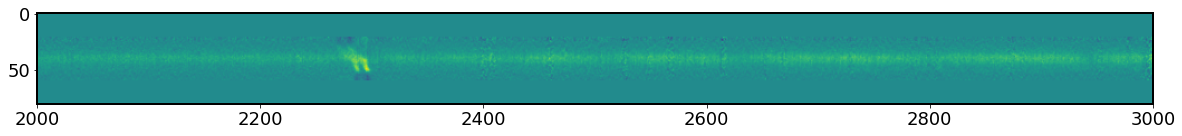

In [7]:
plt.figure(figsize=[20,20])
plt.imshow(hdu2d[0].data)
plt.xlim(2000,3000) #spec is very big, plot just a bit

In [8]:
hdu1d = fits.open(file1d)
hdu1dwht = fits.open(file1dwht)
hdu1d.info()

Filename: ./mos_spectroscopy/observed/legac_M1_v3.7_spec1d_130737.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     715   (6166,)   float32   


In [9]:
hdu1d[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    1 / number of data axes                            
NAXIS1  =                 6166 / length of data axis 1                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-01-26T12:24:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO     '           / European Southern Observatory                  
MJD-OBS =       57040.16930682 / Obs start 2015-01-18T04:03:48.109              
DATE-OBS= '2015-01-18T04:03:48.108' / Date of observation                       
EXPTIME =             1199.997 / Total integration time. 00:19:59.997           
TELESCOP= 'ESO-VLT-U3'      

In [10]:
flux = hdu1d[0].data
wht = hdu1dwht[0].data
unc = 1./ np.sqrt(wht)
wave = np.arange(flux.shape[0])*hdu1d[0].header['CD1_1'] + hdu1d[0].header['CRVAL1']

spec_unit = u.Unit('10^-19 erg s^-1 cm^-2 angstrom^-1')
dataspec = QTable([wave*u.angstrom, flux*spec_unit, wht, unc*spec_unit], 
                   names=('wavelength','flux','weight','uncertainty'))
dataspec_sub = dataspec[dataspec['weight']>0.]
dataspec_sub

wavelength,flux,weight,uncertainty
Angstrom,1e-19 erg / (Angstrom cm2 s),,1e-19 erg / (Angstrom cm2 s)
float64,float32,float32,float32
6711.1,23.666839599609375,0.12069558,2.878420829772949
6711.7,29.432254791259766,0.12049745,2.880786418914795
6712.3,21.171649932861328,0.121845,2.864812135696411
6712.900000000001,19.253450393676758,0.12212322,2.8615469932556152
6713.5,23.544490814208984,0.121006384,2.8747220039367676
6714.1,28.942758560180664,0.12019064,2.884460926055908
...,...,...,...
9187.3,42.11676025390625,0.12641488,2.812554121017456


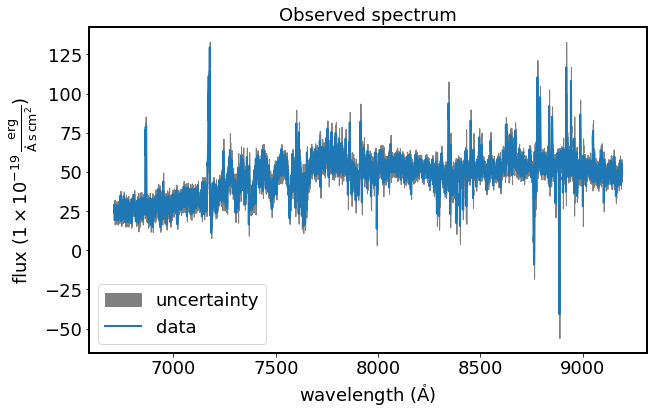

In [11]:
plt.figure(figsize=[10,6])
plt.fill_between(dataspec_sub['wavelength'],
                 dataspec_sub['flux']+dataspec_sub['uncertainty'],
                 dataspec_sub['flux']-dataspec_sub['uncertainty'],
                 color='gray',label="uncertainty")
plt.plot(dataspec_sub['wavelength'],dataspec_sub['flux'], label="data")
plt.xlabel("wavelength ({:latex})".format(dataspec_sub['wavelength'].unit))
plt.ylabel("flux ({:latex})".format(dataspec_sub['flux'].unit))
plt.title("Observed spectrum")
plt.legend()
plt.show()

In [12]:
#write Spectrum1D object
spec1d = Spectrum1D(spectral_axis=dataspec_sub['wavelength'], 
                    flux=dataspec_sub['flux'], 
                    uncertainty=StdDevUncertainty(dataspec_sub['uncertainty']))

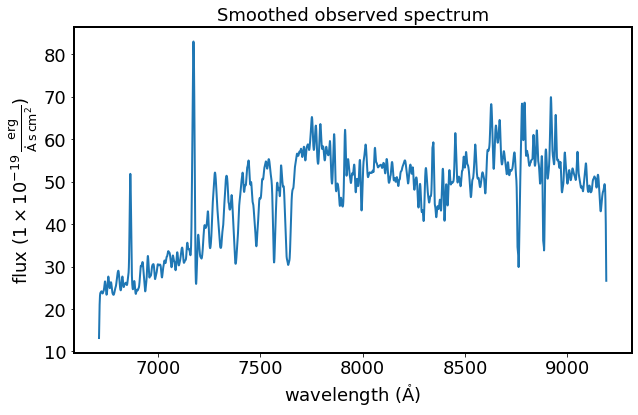

In [13]:
spec1d_gsmooth = gaussian_smooth(spec1d, stddev=5)
plt.figure(figsize=[10,6])
plt.plot(spec1d_gsmooth.spectral_axis,spec1d_gsmooth.flux)
plt.xlabel("wavelength ({:latex})".format(spec1d_gsmooth.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_gsmooth.flux.unit))
plt.title("Smoothed observed spectrum")
plt.show()

In [14]:
cont_spec1d = fit_generic_continuum(spec1d)
cont_fit = cont_spec1d(spec1d.spectral_axis)


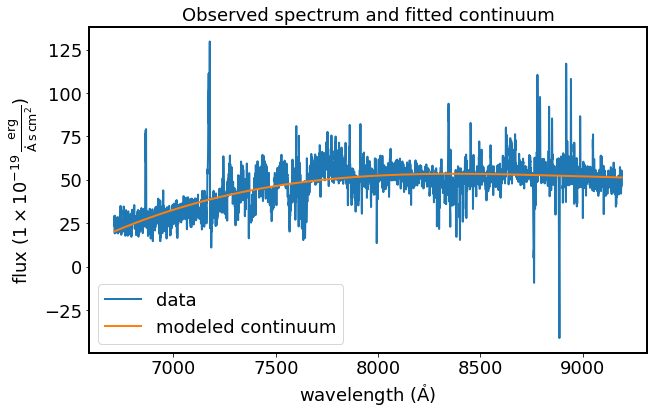

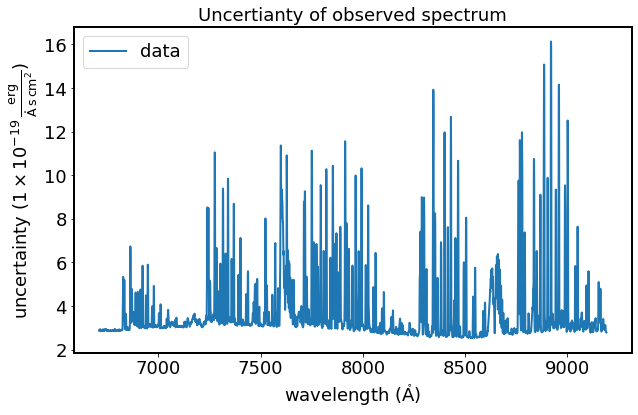

In [15]:
plt.figure(figsize=[10,6])
plt.plot(spec1d.spectral_axis, spec1d.flux, label="data")
plt.plot(spec1d.spectral_axis, cont_fit, label="modeled continuum")
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.legend()
plt.title("Observed spectrum and fitted continuum")
plt.show()

plt.figure(figsize=[10,6])
plt.plot(spec1d.spectral_axis, spec1d.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d.uncertainty.unit))
plt.legend()
plt.title("Uncertianty of observed spectrum")
plt.show()

In [16]:
spec1d_sub = spec1d - cont_fit
spec1d_sub

<Spectrum1D(flux=<Quantity [ 3.25233618,  8.98793999,  0.6975409 , ...,  3.94742237,
            4.04601244, -4.78246239] 1e-19 erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [6711.1, 6711.7, 6712.3, ..., 9189.1, 9189.7, 9190.3] Angstrom>, uncertainty=StdDevUncertainty([2.8784208, 2.8807864, 2.8648121, ..., 2.7904222,
                   2.7935767, 2.7887232]))>

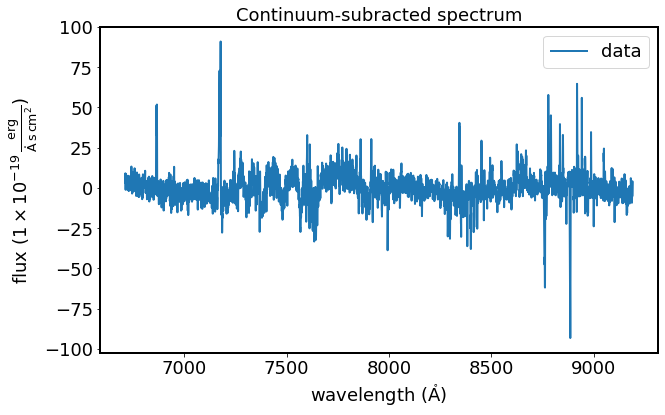

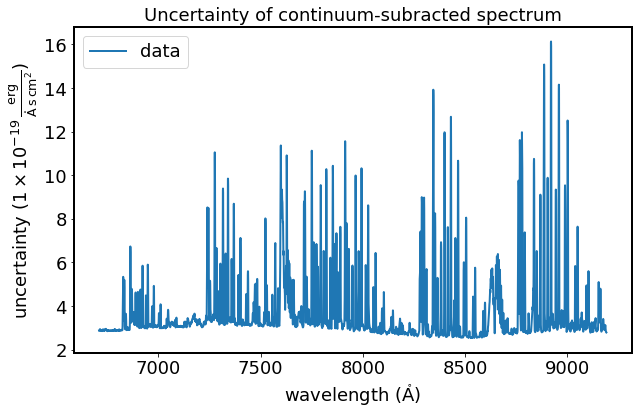

In [17]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subracted spectrum")
plt.show()

plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.uncertainty.array, label="data")
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("uncertainty ({:latex})".format(spec1d_sub.uncertainty.unit))
plt.legend()
plt.title("Uncertainty of continuum-subracted spectrum")
plt.show()

## Look for the lines

In [18]:
lines = find_lines_derivative(spec1d_sub, flux_threshold=50)
lines

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
7171.3,emission,764
7176.7,emission,773
8778.7,emission,3422
8919.1,emission,3637
8761.9,absorption,3394
8885.5,absorption,3581


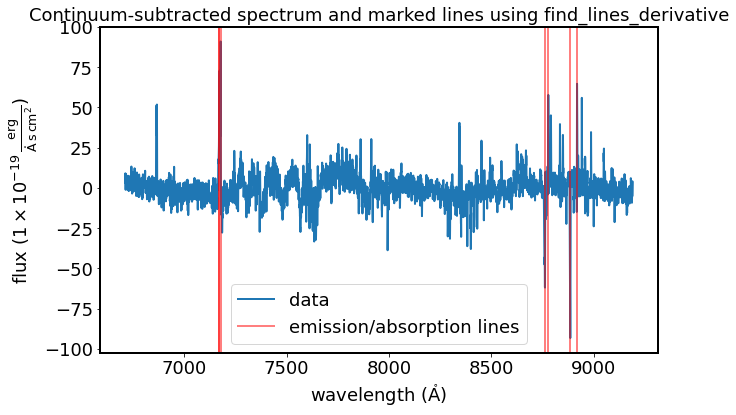

In [19]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission/absorption lines')
for line in lines:
    plt.axvline(line['line_center'].value, color='red',alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_derivative")
plt.show()


Optimizing

In [20]:
lines = find_lines_threshold(spec1d_sub, noise_factor=6)
lines

line_center,line_type,line_center_index
Angstrom,,
float64,str10,int64
6862.3,emission,252
6864.1,emission,255
6865.9,emission,258
7177.3,emission,774
7434.7,emission,1200
7747.3,emission,1721
...,...,...
8332.3,absorption,2688


In [21]:
len(lines)

23

In [22]:
type(lines)

astropy.table.table.QTable

In [23]:
lines['line_type'].value

array(['emission', 'emission', 'emission', 'emission', 'emission',
       'emission', 'emission', 'emission', 'emission', 'emission',
       'emission', 'absorption', 'absorption', 'absorption', 'absorption',
       'absorption', 'absorption', 'absorption', 'absorption',
       'absorption', 'absorption', 'absorption', 'absorption'],
      dtype='<U10')

In [24]:
lines['line_type'][0]

'emission'

In [25]:
emission_lines = []
emission_fluxes = []
absorption_lines = []
absorption_fluxes = []
for i in range(len(lines)):
    if (lines['line_type'][i] == 'emission'):
        emission_lines.append(lines['line_center'][i].value)
        emission_fluxes.append(spec1d_sub[lines['line_center_index'][i]].flux.value)

    else:
        absorption_lines.append(lines['line_center'][i].value)
        absorption_fluxes.append(spec1d_sub[lines['line_center_index'][i]].flux.value)

    

In [26]:
emission_fluxes

[array([49.23710735]),
 array([51.19986177]),
 array([51.68889832]),
 array([90.84769709]),
 array([19.17478423]),
 array([21.45465855]),
 array([27.25017641]),
 array([20.40030441]),
 array([44.97892694]),
 array([19.99140576]),
 array([55.85972749])]

In [27]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
emission_fluxes_Log = transformer.transform(emission_fluxes)

In [28]:
emission_fluxes_Log

array([[3.91675394],
       [3.95507985],
       [3.96440478],
       [4.52013174],
       [3.00443352],
       [3.1114981 ],
       [3.3410997 ],
       [3.06340515],
       [3.82818318],
       [3.0441131 ],
       [4.04058731]])

In [29]:
np.nanmax(emission_fluxes_Log)

4.5201317388126325

In [30]:
np.nanmin(emission_fluxes_Log)

3.0044335192183222

In [31]:
emission_amps = np.round((emission_fluxes / np.nanmax(emission_fluxes)), decimals=2) #better not logarithmic

In [32]:
emission_amps

array([[0.54],
       [0.56],
       [0.57],
       [1.  ],
       [0.21],
       [0.24],
       [0.3 ],
       [0.22],
       [0.5 ],
       [0.22],
       [0.61]])

In [33]:
emission_amps_Log = transformer.transform(emission_amps)

In [34]:
emission_amps_Log

array([[0.43178242],
       [0.44468582],
       [0.45107562],
       [0.69314718],
       [0.19062036],
       [0.21511138],
       [0.26236426],
       [0.19885086],
       [0.40546511],
       [0.19885086],
       [0.47623418]])

In [35]:
absorption_fluxes

[array([-27.8598385]),
 array([-27.42556472]),
 array([-33.38802721]),
 array([-32.32436654]),
 array([-20.7110931]),
 array([-16.86212502]),
 array([-17.48082836]),
 array([-18.16525933]),
 array([-17.68040615]),
 array([-15.1945997]),
 array([-61.98897681]),
 array([-93.33453669])]

In [36]:
absorption_fluxes_Log = np.around(transformer.transform(np.abs(absorption_fluxes)), decimals=2)

In [37]:
absorption_fluxes_Log

array([[3.36],
       [3.35],
       [3.54],
       [3.51],
       [3.08],
       [2.88],
       [2.92],
       [2.95],
       [2.93],
       [2.78],
       [4.14],
       [4.55]])

In [38]:
np.nanmax(absorption_fluxes_Log)

4.55

In [39]:
np.nanmin(absorption_fluxes_Log)

2.78

In [40]:
absorption_amps = np.round(np.abs(absorption_fluxes) / np.nanmax(np.abs(absorption_fluxes)), decimals=2) #better not logarithmic

In [41]:
absorption_amps

array([[0.3 ],
       [0.29],
       [0.36],
       [0.35],
       [0.22],
       [0.18],
       [0.19],
       [0.19],
       [0.19],
       [0.16],
       [0.66],
       [1.  ]])

In [42]:
emission_lines = np.around(emission_lines, decimals=0)

In [43]:
emission_lines

array([6862., 6864., 6866., 7177., 7435., 7747., 7753., 7755., 8791.,
       8924., 8942.])

In [44]:
absorption_lines

[7184.5,
 7567.3,
 7634.5,
 7642.9,
 7647.7,
 8325.1,
 8332.3,
 8358.7,
 8371.3,
 8529.7,
 8762.5,
 8886.1]

In [45]:
absorption_lines = np.around(absorption_lines, decimals=0)

In [46]:
absorption_lines

array([7184., 7567., 7634., 7643., 7648., 8325., 8332., 8359., 8371.,
       8530., 8762., 8886.])

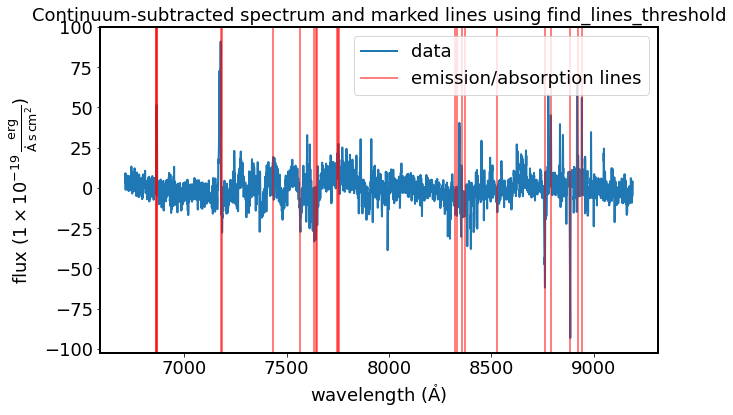

In [47]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission/absorption lines')
for line in lines:
    plt.axvline(line['line_center'].value, color='red', alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")
#plt.savefig("AbsEmis.png")

plt.show()

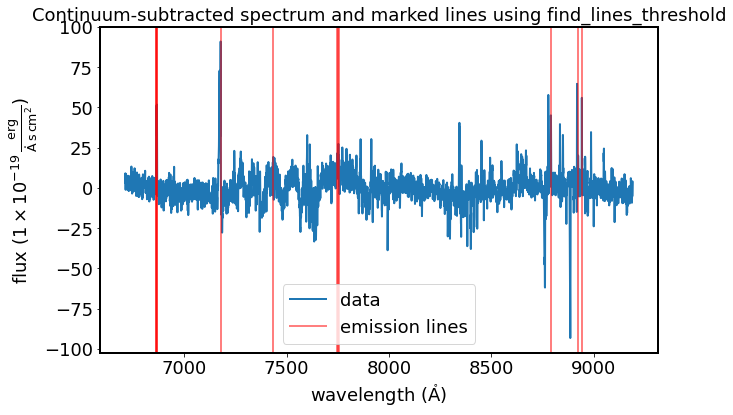

In [48]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission lines')
for line in lines:
    if (line['line_type'] == 'emission'):
        plt.axvline(line['line_center'].value, color='red', alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")
#plt.savefig("Emis.png")
plt.show()

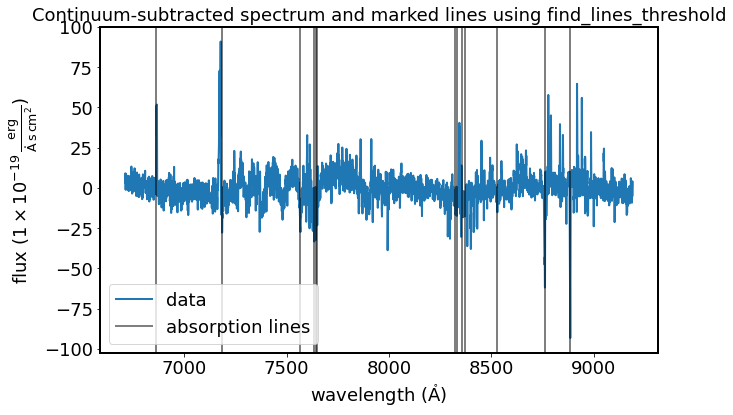

In [49]:
plt.figure(figsize=[10,6])
plt.plot(spec1d_sub.spectral_axis,spec1d_sub.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="black", alpha=0.5, label='absorption lines')
for line in lines:
    if (line['line_type'] == 'absorption'):
        plt.axvline(line['line_center'].value, color='black', alpha=0.5)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.legend()
plt.title("Continuum-subtracted spectrum and marked lines using find_lines_threshold")
#plt.savefig("Abs.png")
plt.show()

## Sonification

In [50]:
from pythonosc import udp_client

Play

In [51]:
print ("Emission lines")

client_s = udp_client.SimpleUDPClient("127.0.0.1", 1000)
client_s.send_message("/s", 1)

client0 = udp_client.SimpleUDPClient("127.0.0.1", 9950)
client0.send_message("/0", emission_lines[0]/10)
client_a = udp_client.SimpleUDPClient("127.0.0.1",9970)
client_a.send_message("/a", emission_amps[0])
print(emission_lines[0])

client1 = udp_client.SimpleUDPClient("127.0.0.1", 9951) 
client1.send_message("/1", emission_lines[1]/10)
client_b = udp_client.SimpleUDPClient("127.0.0.1",9971)
client_b.send_message("/b", emission_amps[1])
print(emission_lines[1])

client2 = udp_client.SimpleUDPClient("127.0.0.1", 9952) 
client2.send_message("/2", emission_lines[2]/10)
client_c = udp_client.SimpleUDPClient("127.0.0.1",9972)
client_c.send_message("/c", emission_amps[2])
print(emission_lines[2])

client3 = udp_client.SimpleUDPClient("127.0.0.1", 9953) 
client3.send_message("/3", emission_lines[3]/10)
client_d = udp_client.SimpleUDPClient("127.0.0.1",9973)
client_d.send_message("/d", emission_amps[3])
print(emission_lines[3])

client4 = udp_client.SimpleUDPClient("127.0.0.1", 9954) 
client4.send_message("/4", emission_lines[4]/10)
client_e = udp_client.SimpleUDPClient("127.0.0.1",9974)
client_e.send_message("/e", emission_amps[4])
print(emission_lines[4])


print("Absorption lines")

client5 = udp_client.SimpleUDPClient("127.0.0.1", 9955)   
client5.send_message("/5", absorption_lines[0]/10)
client_f = udp_client.SimpleUDPClient("127.0.0.1",9975)
client_f.send_message("/f", absorption_amps[0])
print(absorption_lines[0])

client6 = udp_client.SimpleUDPClient("127.0.0.1", 9956) 
client6.send_message("/6", absorption_lines[1]/10)
client_g = udp_client.SimpleUDPClient("127.0.0.1",9976)
client_g.send_message("/g", absorption_amps[1])
print(absorption_lines[1])

client7 = udp_client.SimpleUDPClient("127.0.0.1", 9957) 
client7.send_message("/7", absorption_lines[2]/10)
client_h = udp_client.SimpleUDPClient("127.0.0.1",9977)
client_h.send_message("/h", absorption_amps[2])
print(absorption_lines[2])

client8 = udp_client.SimpleUDPClient("127.0.0.1", 9958) 
client8.send_message("/8", absorption_lines[3]/10)
client_i = udp_client.SimpleUDPClient("127.0.0.1",9978)
client_i.send_message("/i", absorption_amps[3])
print(absorption_lines[3])

client9 = udp_client.SimpleUDPClient("127.0.0.1", 9959) 
client9.send_message("/9", absorption_lines[4]/10)
client_j = udp_client.SimpleUDPClient("127.0.0.1",9979)
client_j.send_message("/j", absorption_amps[4])
print(absorption_lines[4])

client10 = udp_client.SimpleUDPClient("127.0.0.1", 9960)   
client10.send_message("/10", absorption_lines[5]/10)
client_k = udp_client.SimpleUDPClient("127.0.0.1",9980)
client_k.send_message("/k", absorption_amps[5])
print(absorption_lines[5])

client11 = udp_client.SimpleUDPClient("127.0.0.1", 9961) 
client11.send_message("/11", absorption_lines[6]/10)
client_l = udp_client.SimpleUDPClient("127.0.0.1",9981)
client_l.send_message("/l", absorption_amps[6])
print(absorption_lines[6])

client12 = udp_client.SimpleUDPClient("127.0.0.1", 9962) 
client12.send_message("/12", absorption_lines[7]/10)
client_m = udp_client.SimpleUDPClient("127.0.0.1",9982)
client_m.send_message("/m", absorption_amps[7])
print(absorption_lines[7])

client13 = udp_client.SimpleUDPClient("127.0.0.1", 9963) 
client13.send_message("/13", absorption_lines[8]/10)
client_n = udp_client.SimpleUDPClient("127.0.0.1",9983)
client_n.send_message("/n", absorption_amps[8])
print(absorption_lines[8])

client14 = udp_client.SimpleUDPClient("127.0.0.1", 9964) 
client14.send_message("/14", absorption_lines[9]/10)
client_o = udp_client.SimpleUDPClient("127.0.0.1",9984)
client_o.send_message("/o", absorption_amps[9])
print(absorption_lines[9])

client15 = udp_client.SimpleUDPClient("127.0.0.1", 9965)   
client15.send_message("/15", absorption_lines[10]/10)
client_p = udp_client.SimpleUDPClient("127.0.0.1",9985)
client_p.send_message("/p", absorption_amps[10])
print(absorption_lines[10])

client16 = udp_client.SimpleUDPClient("127.0.0.1", 9966) 
client16.send_message("/16", absorption_lines[11]/10)
client_q = udp_client.SimpleUDPClient("127.0.0.1",9986)
client_q.send_message("/q", absorption_amps[11])
print(absorption_lines[11])

client17 = udp_client.SimpleUDPClient("127.0.0.1", 9967) 
client17.send_message("/17", absorption_lines[12]/10)
client_r = udp_client.SimpleUDPClient("127.0.0.1",9987)
client_r.send_message("/r", absorption_amps[12])
print(absorption_lines[12])

Emission lines
6862.0
6864.0
6866.0
7177.0
7435.0
Absorption lines
7184.0
7567.0
7634.0
7643.0
7648.0
8325.0
8332.0
8359.0
8371.0
8530.0
8762.0
8886.0


IndexError: index 12 is out of bounds for axis 0 with size 12

Stop

In [52]:
client_s.send_message("/s", 0)
client0.send_message("/0", 0)
client1.send_message("/1", 0)
client2.send_message("/2", 0)
client3.send_message("/3",0)
client4.send_message("/4", 0)
client5.send_message("/5", 0)
client6.send_message("/6", 0)
client7.send_message("/7", 0)
client8.send_message("/8", 0)
client9.send_message("/9",0)
client10.send_message("/10", 0)
client11.send_message("/11", 0)
client12.send_message("/12", 0)
client13.send_message("/13",0)
client14.send_message("/14", 0)
client15.send_message("/15", 0)
client16.send_message("/16", 0)
client17.send_message("/17", 0)

client_a.send_message("/a", 0)
client_b.send_message("/b", 0)
client_c.send_message("/c", 0)
client_d.send_message("/d", 0)
client_e.send_message("/e", 0)
client_f.send_message("/f", 0)
client_g.send_message("/g", 0)
client_h.send_message("/h", 0)
client_i.send_message("/i", 0)
client_j.send_message("/j", 0)
client_k.send_message("/k", 0)
client_l.send_message("/l", 0)
client_m.send_message("/m", 0)
client_n.send_message("/n", 0)
client_o.send_message("/o", 0)
client_p.send_message("/p", 0)
client_q.send_message("/q", 0)

In [1]:
import session_info
session_info.show()